[CACHE] log10C=+0.247241 (C=1.76702) -> CV f1_macro=0.8470
[CV] log10C=+3.704286 (C=5061.58) -> CV f1_macro=0.8422
[CACHE] log10C=+0.247241 (C=1.76702) -> CV f1_macro=0.8470
[CV] log10C=+2.391964 (C=246.583) -> CV f1_macro=0.8416
[CACHE] log10C=+0.247241 (C=1.76702) -> CV f1_macro=0.8470
[CV] log10C=+1.591951 (C=39.0797) -> CV f1_macro=0.8425
[CACHE] log10C=+0.247241 (C=1.76702) -> CV f1_macro=0.8470
[CV] log10C=-1.063888 (C=0.0863201) -> CV f1_macro=0.8599
[CACHE] log10C=-1.063888 (C=0.0863201) -> CV f1_macro=0.8599
[CV] log10C=-1.064033 (C=0.0862913) -> CV f1_macro=0.8599
[CV] log10C=+0.239163 (C=1.73445) -> CV f1_macro=0.8470
[CACHE] log10C=+0.247241 (C=1.76702) -> CV f1_macro=0.8470
[CV] log10C=+3.738236 (C=5473.14) -> CV f1_macro=0.8417
[CACHE] log10C=+3.704286 (C=5061.58) -> CV f1_macro=0.8422
[CV] log10C=+2.370946 (C=234.934) -> CV f1_macro=0.8421
[CACHE] log10C=+2.391964 (C=246.583) -> CV f1_macro=0.8416
[CV] log10C=+1.575718 (C=37.646) -> CV f1_macro=0.8422
[CACHE] log10C=+1.5

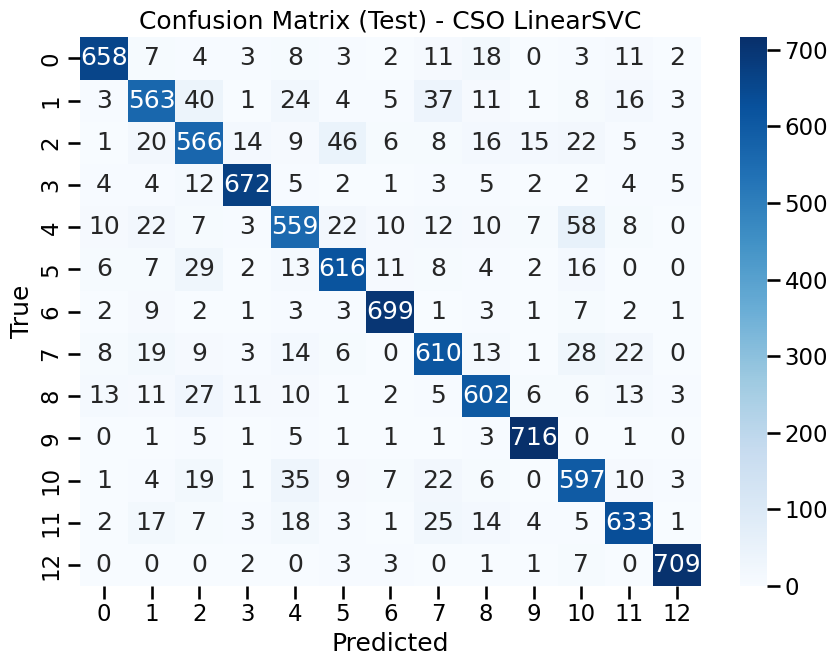

['models/svm/linear_svc_cso_results.joblib']

In [1]:
import os
import time
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.exceptions import ConvergenceWarning

from cso import CSO

sns.set_context("talk")
np.random.seed(42)

# 1) Load embeddings + labels (MATCH GRID)
SAVE_DIR = "models/svm"
X_train = np.load(f"{SAVE_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_DIR}/X_test_emb.npy")
y_test  = np.load(f"{SAVE_DIR}/y_test.npy")

# 2) Bounds (same range as grid's logspace(-2, 4, ...))
bounds = [(-2.0, 4.0)]  # log10(C)

# 3) CV (MATCH GRID)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Cache (local)
CACHE_PATH = f"{SAVE_DIR}/svm_cso_eval_cache_f1_macro.joblib"
eval_cache = joblib.load(CACHE_PATH) if os.path.exists(CACHE_PATH) else {}

def _decode_params(x_vec):
    log_C = float(x_vec[0])
    C = 10 ** log_C
    return log_C, C

def svm_fitness(x_vec):
    log_C, C = _decode_params(x_vec)

    log_C_key = round(log_C, 6)
    cache_key = ("LinearSVC", log_C_key, "f1_macro")

    if cache_key in eval_cache:
        f1m = eval_cache[cache_key]
        print(f"[CACHE] log10C={log_C_key:+.6f} (C={C:.6g}) -> CV f1_macro={f1m:.4f}")
        return -f1m

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(
            C=C,
            class_weight="balanced",
            random_state=42,
        ))
    ])

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = cross_val_score(
            clf, X_train, y_train,
            cv=skf,
            scoring="f1_macro",
            n_jobs=1  # MATCH GRID N_JOBS=1
        )

    f1m = float(scores.mean())
    eval_cache[cache_key] = f1m
    joblib.dump(eval_cache, CACHE_PATH)
    print(f"[CV] log10C={log_C_key:+.6f} (C={C:.6g}) -> CV f1_macro={f1m:.4f}")
    return -f1m

# 5) Budget fairness:
P = 6
Tmax = 2

t0 = time.time()
cso = CSO(
    fitness=svm_fitness,
    P=P,
    n=1,
    bound=bounds,
    Tmax=Tmax,
    verbose=True,
    plot=False,
    min=True
)
cso.execute()
print(f"Elapsed (CSO): {time.time() - t0:.1f}s")

best_vec = cso.best
log_C_best, C_best = _decode_params(best_vec)

# 6) Train best on full train, eval on test (MATCH GRID)
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        C=C_best,
        class_weight="balanced",
        random_state=42,
    ))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy : {acc:.4f}")
print(f"Test F1-macro : {f1m:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

labels = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Test) - CSO LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 7) Save outputs (local)
joblib.dump(best_model, f"{SAVE_DIR}/linear_svc_cso.joblib")
joblib.dump(
    {
        "log10_C": float(log_C_best),
        "C": float(C_best),
        "cv_objective": "f1_macro",
        "cv_strategy": "5-fold StratifiedKFold, shuffle=True, random_state=42",
        "test_accuracy": float(acc),
        "test_f1_macro": float(f1m),
        "budget": {"P": P, "Tmax": Tmax, "evals": P * Tmax},
    },
    f"{SAVE_DIR}/linear_svc_cso_results.joblib"
)

In [2]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
SAVE_EMBEDDINGS_DIR = 'models/embeddings_train_test'
SAVE_MODEL_DIR = 'models/svm_opt'


In [5]:
import numpy as np
import joblib
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# 1️⃣ Load dữ liệu
# =========================

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")

X_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =========================
# 2️⃣ Pipeline: Scaling + LinearSVC
# =========================
clf = Pipeline([
    ("scaler", StandardScaler()),  # rất quan trọng cho SVM
    ("svm", LinearSVC(
        C=0.01, # giá trị C đã được tối ưu từ bước trước
        class_weight="balanced",  # nên bật nếu data lệch lớp
        random_state=42
    ))
])

# =========================
# 3️⃣ Train
# =========================
print(">> Training LinearSVC...")
clf.fit(X_train, y_train)

# =========================
# 4️⃣ Evaluate
# =========================
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# =========================
# 5️⃣ Save model
# =========================
joblib.dump(clf, f"{SAVE_MODEL_DIR}/linear_svc_opt_cs.joblib")
print(">> Model saved to linear_svc_opt_cs.joblib")

Train shape: (37698, 768)
Test shape : (9425, 768)
>> Training LinearSVC...
Accuracy : 0.8741
F1-macro : 0.8739

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       730
           1       0.81      0.79      0.80       716
           2       0.86      0.87      0.86       714
           3       0.95      0.94      0.95       734
           4       0.81      0.83      0.82       733
           5       0.87      0.86      0.87       710
           6       0.96      0.97      0.96       735
           7       0.81      0.87      0.84       714
           8       0.87      0.86      0.86       733
           9       0.97      0.97      0.97       726
          10       0.81      0.78      0.79       731
          11       0.94      0.94      0.94       721
          12       0.79      0.78      0.78       728

    accuracy                           0.87      9425
   macro avg       0.87      0.87      0.87      942

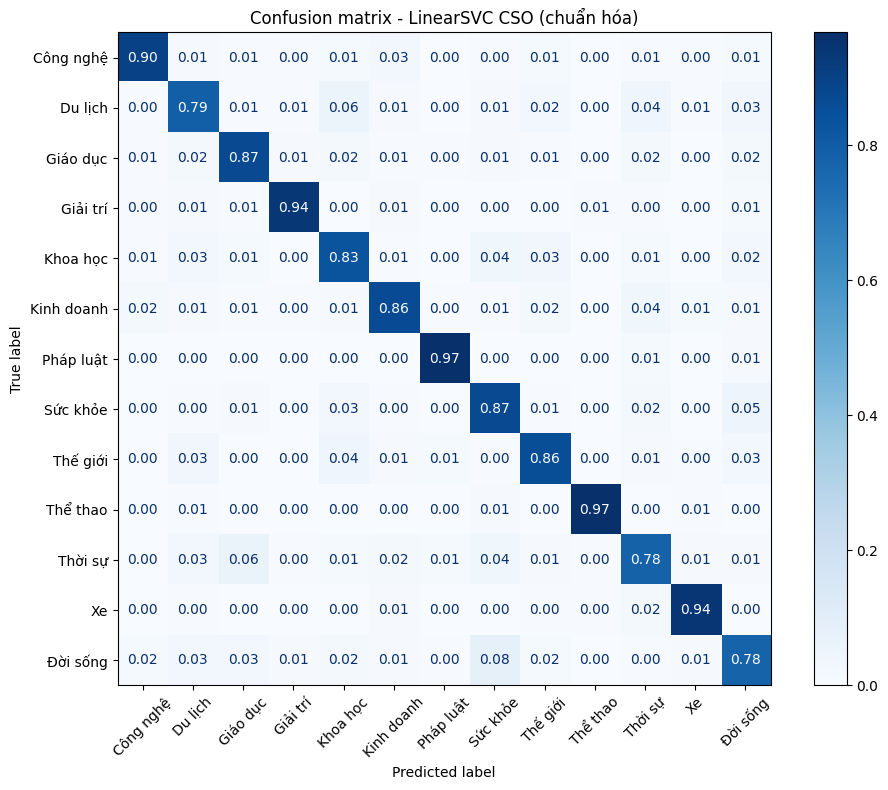

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


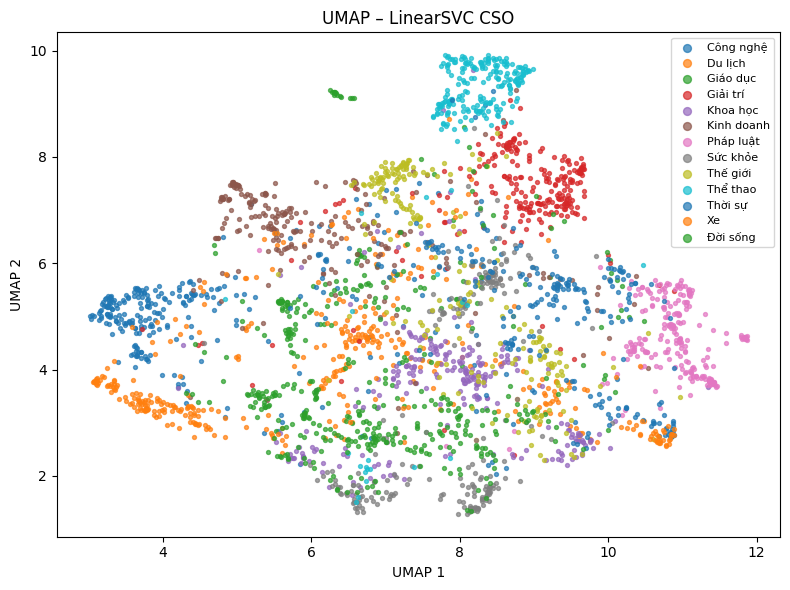

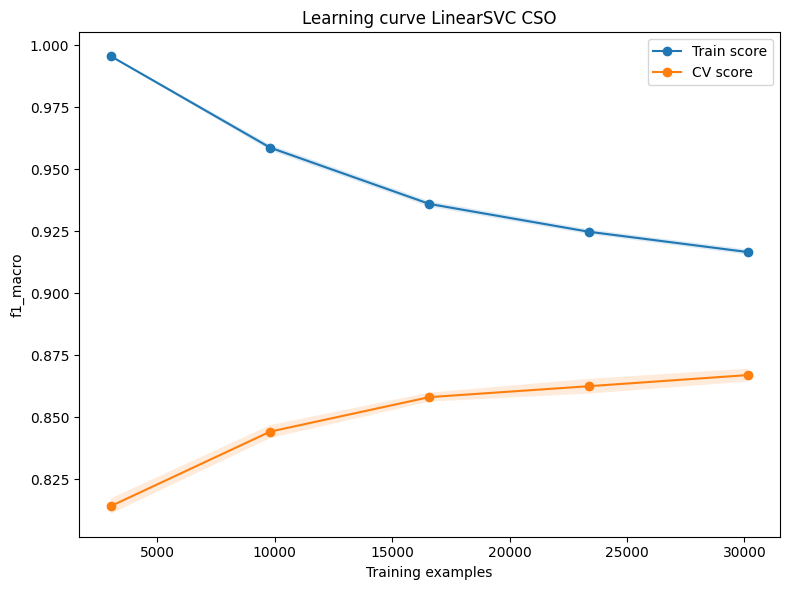

In [3]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL LINEAR ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/linear_svc_opt_cs.joblib")

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")

LABEL_NAMES = [
    "Công nghệ",     # 0
    "Du lịch",       # 1
    "Giáo dục",      # 2
    "Giải trí",      # 3
    "Khoa học",      # 4
    "Kinh doanh",    # 5
    "Pháp luật",     # 6
    "Sức khỏe",      # 7
    "Thế giới",      # 8
    "Thể thao",      # 9
    "Thời sự",       # 10
    "Xe",            # 11
    "Đời sống",      # 12
]

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix - LinearSVC CSO",
    label_names=LABEL_NAMES
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    label_names=LABEL_NAMES,
    max_points=3000,
    title="UMAP – LinearSVC CSO"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve LinearSVC CSO"
)